## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
print('Number of rows = {}'.format(df.shape[0]))

Number of rows = 294478


c. The number of unique users in the dataset.

In [4]:
print('Number of unique users = {}'.format(df.user_id.nunique()))

Number of unique users = 290584


d. The proportion of users converted.

In [5]:
print('Proportion of users converted = {}%'.format(round(df.converted.mean() * 100)))

Proportion of users converted = 12.0%


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
match = (df['group'] == 'treatment') == (df['landing_page'] == 'new_page')
num_not_match = df[match == False].shape[0]
print('Not match times =  {}'.format(num_not_match))

Not match times =  3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.copy()
df2 = df2[match]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print('Number of unique users ids = {}'.format(df2.user_id.nunique()))

Number of unique users ids = 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
repeated_id = df2[df2.user_id.duplicated()].user_id.iloc[0]
print('Repeated user_id = {}'.format(repeated_id))

Repeated user_id = 773192


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset=['user_id'], inplace=True)
df2[df2.user_id == repeated_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
conv = df2.converted.mean()
print('Probability of individual converting regardless received page = {}'.format(conv))

Probability of individual converting regardless received page = 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
conv_control = df2[df2.group == 'control'].converted.mean()
print('conv control= {}.'.format(conv_control))

conv control= 0.1203863045004612.


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
conv_treatment = df2[df2.group == 'treatment'].converted.mean()
print('conv treatment = {}.'.format(conv_treatment))

conv treatment = 0.11880806551510564.


d. What is the probability that an individual received the new page?

In [17]:
new_page = (df2['landing_page'] == "new_page").mean()
print('new page probability =  {}'.format(new_page))

new page probability =  0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

There is no sufficient evidence to conclude that the new treatment page leads to more conversions, it is even higher conv_control > conv_treatment.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0
$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
pnew = conv
print('pnew = {}'.format(pnew))

pnew = 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null?

In [19]:
pold = conv
print('pold = {}'.format(pold))

pold = 0.11959708724499628


c. What is $n_{new}$?

In [20]:
nnew = df2[df2.landing_page == 'new_page'].shape[0]
print('nnew = {}'.format(nnew))

nnew = 145310


d. What is $n_{old}$?

In [21]:
nold = df2[df2.landing_page == 'old_page'].shape[0]
print('nold = {}'.format(nold))

nold = 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_conv_mean = np.random.choice([0, 1], size=nnew, p=[(1 - pnew), pnew]).mean()
print('new_page_conv_mean = {}'.format(new_page_conv_mean))

new_page_conv_mean = 0.11932420342715573


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_conv_mean = np.random.choice([0, 1], size=nold, p=[(1 - pold), pold]).mean()
print('old_page_converted_mean = {}'.format(old_page_conv_mean))

old_page_converted_mean = 0.12020044880708179


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
print('pnew-pold = {}'.format(new_page_conv_mean - old_page_conv_mean))

pnew-pold = -0.0008762453799260606


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_conv_mean = np.random.choice([0, 1], size=nnew, p=[(1 - pnew), pnew]).mean()
    old_page_conv_mean = np.random.choice([0, 1], size=nold, p=[(1 - pold), pold]).mean()
    p_diffs.append(new_page_conv_mean - old_page_conv_mean)

i. Plot a histogram of the **p_diffs**.

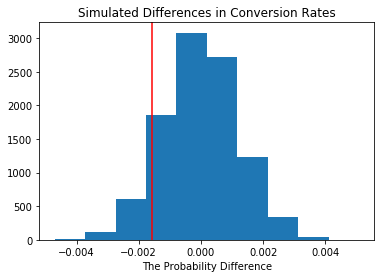

In [26]:
p_diffs = np.asarray(p_diffs)
obs_diff = conv_treatment - conv_control
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates")
plt.xlabel("The Probability Difference")
plt.axvline(obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
proportion = (p_diffs >= obs_diff).mean()
print('proportion = {}'.format(proportion))

proportion = 0.9012


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- Actual difference represents the difference between converted rates of new page and old page, based on our data.
- p-value
- determines the probability of obtaining our observed statistic if null hypothesis is true, and to reject the null hypothesis, the p-value should be below our alpha level of 0.05. in my calculation the p-value = 0.9026, it is very high to be able to reject the null hypothesis. There is no sufficient evidence to say that there is convertion difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [29]:
conv_old_count = df2.query('group == "control" & converted == 1')['converted'].count()
conv_new_count = df2.query('group == "treatment" & converted == 1')['converted'].count()
print('conv_old_count = {}\nconv_new_count = {}\nnold = {}\nnnew = {}'.format(conv_old_count, conv_new_count, nold, nnew))

conv_old_count = 17489
conv_new_count = 17264
nold = 145274
nnew = 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([conv_new_count, conv_old_count], [nnew, nold], alternative='larger')
print('z_score = {}\np_value = {}'.format(z_score, p_value))

z_score = -1.3109241984234394
p_value = 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

z-score is the number of standard deviations from the mean, Yes, z-score and p-value agreed with the findings in parts j and k

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression as we deal with binary output

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  First we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
logit_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-04 04:41 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

p-value are 0.19, This is because the Logit Regression is based on a two-tailed test. 0.19 > 0.05 so we still can not reject our null hypothesis, and this value also has lower value than the p-value calculated using the z-score function, and it is different because the added intercept.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The convert rate could be related to some other features like nationality, gender or age, and by doing analysis to other features could reveal hidden values  of the new page for some users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

In [34]:
df_new = pd.read_csv('./countries.csv').set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [35]:
# Check what countries are in the new dataset
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [36]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [37]:
# Train the model
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']]).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-04 04:41 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
uk             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
us             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

Does it appear that country had an impact on conversion?

p-values are higher than 0.05, so we cannot reject the null hypothesis, and conculde that countries don't affect by much differences in the conversion rates

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
# Create additional columns specifying what user/country converted
df_new['us_page'], df_new['uk_page'] = df_new['us'] * df_new['ab_page'], df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [39]:
### Fit Your Linear Model And Obtain the Results
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']]).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-04 04:41 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
us             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
uk             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
us_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
uk_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

p-values for all variables it turns out they are higher than 0.05, so we can say that interactions between page and country have no significant effects on conversion

## Conclusions

There is no sufficient evidence to suggest that the new page results in more conversions than the old one, However there are other variables identified regarding users which could result in rejecting our null hypothesis, According to my analysis and opinion I would sugges to drop the new page because It doesn't give that much value until furthur analysis to be made.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])